In [1]:
# docker build -t mri .
# docker run --runtime nvidia --rm -it -v $PWD:/w -w /w mri bash
import os
os.chdir('/w')
import sys 
sys.path.append('lib')

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import cv2
from src.util import read_fastmri, plot, print_info, centre_crop

## 1. Standard IFT

In [3]:
def standard_IFT(k_space):
    k_space = np.fft.ifftshift(k_space, axes=(-2,-1))
    k_space = np.fft.ifft2(k_space, norm='ortho', axes=(-2,-1))
    transformed_img = np.fft.fftshift(k_space, axes=(-2,-1))
    transformed_img = np.abs(transformed_img)
    transformed_img = (transformed_img - transformed_img.min()) / (transformed_img.max() - transformed_img.min())
    return transformed_img

fully_smapled_kspace: (16, 4, 640, 322)
undersampled_kspace: (16, 4, 640, 322)


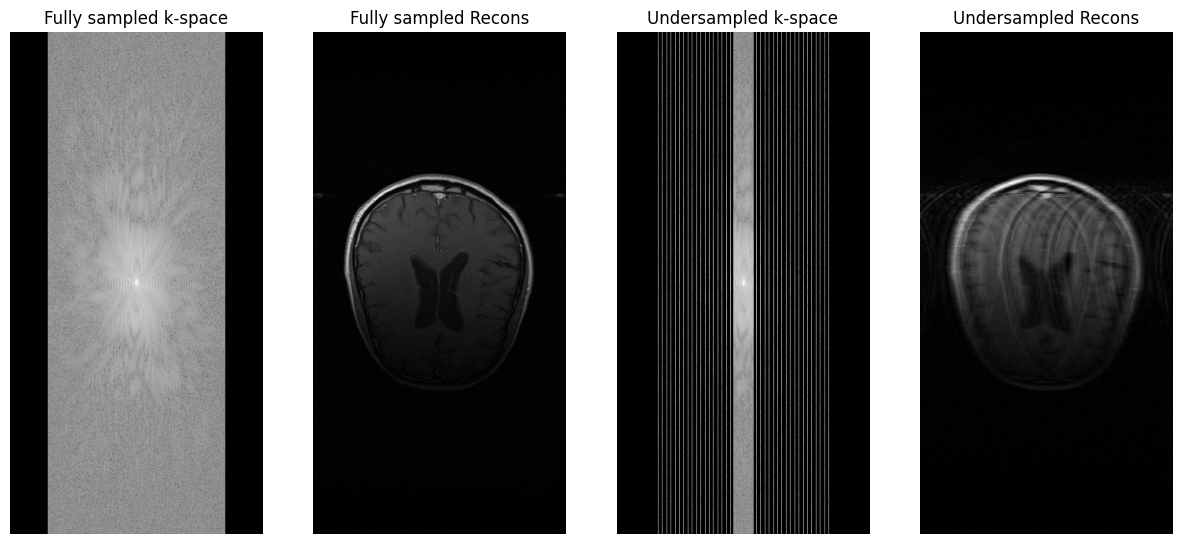

In [4]:
fully_sampled_kspace, _ = read_fastmri("data/task_1/file_brain_AXT1POST_207_2070829.h5")
fully_smaple_image_IFT = standard_IFT(fully_sampled_kspace)
print("fully_smapled_kspace:", fully_sampled_kspace.shape)


undersampled_kspace, undersampled_rss = read_fastmri("data/task_1/file_brain_AXT1POST_207_2070829_undersampled.h5")
# undersampled_kspace, undersampled_rss = read_fastmri("data/fastmri.h5")
undersampled_image_IFT = standard_IFT(undersampled_kspace)
print("undersampled_kspace:", undersampled_kspace.shape)


plot({"Fully sampled k-space": np.log(np.abs(fully_sampled_kspace[0,0]) + 1e-9),
      "Fully sampled Recons": fully_smaple_image_IFT[0,0],
        "Undersampled k-space": np.log(np.abs(undersampled_kspace[0,0]) + 1e-9),
        "Undersampled Recons": undersampled_image_IFT[0,0]})

## 2. Compressed Sensing (CS)

ISTA( iterative soft thresholding algorithm ) for CS (Compressed Sensing) MRI

`kspace  --IFT-->  multi-coil IMG  --RSS/Mean-->  single coil IMG --> reconstruct`

In [5]:
def resize_4d(data, shape):
    """
    Resize the image to the desired shape
    """
    output_real = np.zeros((*data.shape[:-2],shape[-2], shape[-1]), dtype=np.complex128)
    output_imag = np.zeros((*data.shape[:-2],shape[-2], shape[-1]), dtype=np.complex128)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            output_real[i,j,:,:] = cv2.resize(np.real(data[i,j,:,:]), (shape[-1], shape[-2]))
            output_imag[i,j,:,:] = cv2.resize(np.imag(data[i,j,:,:]), (shape[-1], shape[-2]))

    output = output_real + 1j * output_imag
    return output


## (CS) data preparation

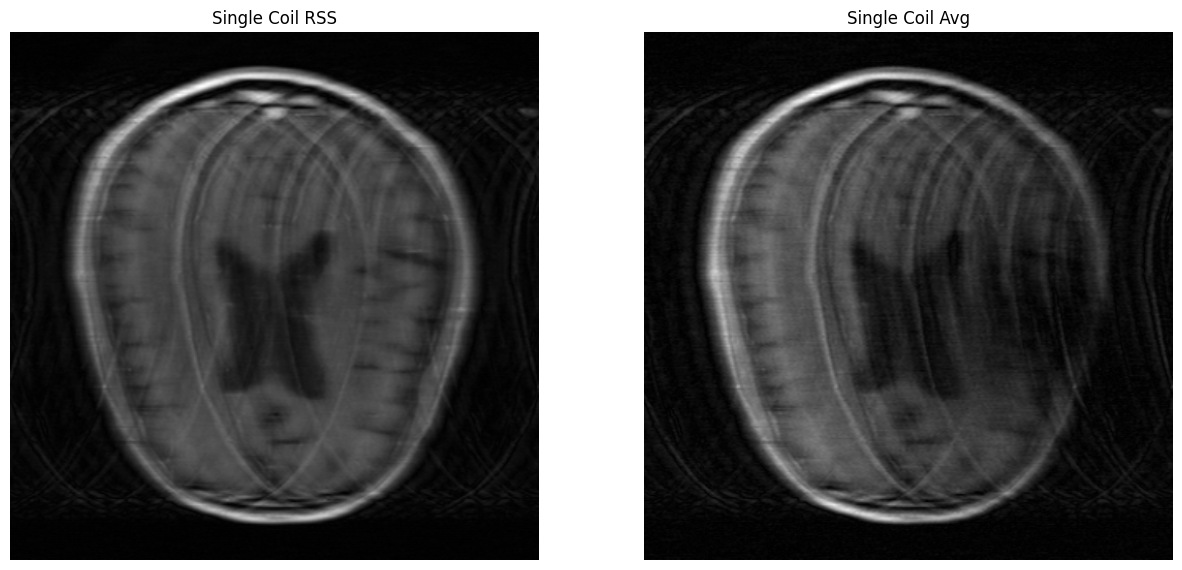

In [6]:
from src.cal import ifft2c, fft2c
cs_undersampled_kspace = undersampled_kspace.copy()
cs_undersampled_kspace = ifft2c(cs_undersampled_kspace)
cs_undersampled_kspace = centre_crop(cs_undersampled_kspace, (320,320))
cs_undersampled_kspace = resize_4d(cs_undersampled_kspace, (512,512))


# Multi coil -> single Coil, either take the mean of the coil or RSS
# RSS 
single_coil_rss = np.sqrt(np.sum(np.abs(cs_undersampled_kspace)**2, axis=1))
# Taking mean of the coil
single_coil_avg = np.mean(cs_undersampled_kspace, axis=1) 
plot({"Single Coil RSS": np.abs(single_coil_rss[0]), "Single Coil Avg": np.abs(single_coil_avg[0])})

In [7]:
# Enhancement
# take the first slice as example
img = single_coil_rss[0]

img = (img - img.min()) / (img.max() - img.min()) # standardize the data to [0,1]
img = (img - img.mean()) / img.std() # enhance contrast

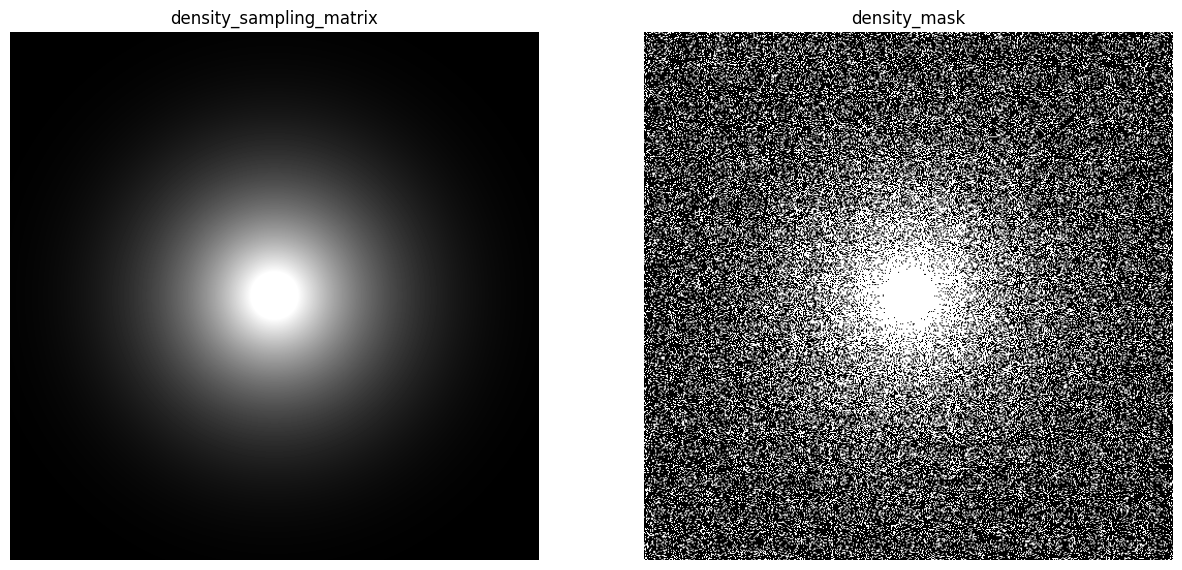

In [8]:
# load density sampling matrix and mask
den_mat = np.load('weight/density_sampling_matrix.npy')
den_mask = np.load('weight/density_mask.npy')
plot({'density_sampling_matrix':den_mat, 'density_mask':den_mask})

In [9]:
from scipy import signal
from src.cal import conv2t
# ============================================  H , Ht , V , Vt ============================================
# finite difference equation operators
# used first order central difference operator, and made into a 3x3. faciliated the convolution operators
h = np.array([[-1/2, 0, 1/2],[-1/2, 0, 1/2],[-1/2, 0, 1/2]])
# h = h.reshape(1,len(h))
hff = np.fliplr(np.flipud(h))
# hf = np.flipud(h)
H = lambda x: signal.convolve2d(x, hff)
Ht = lambda x: conv2t(h, x)

# v = np.array([[1],[0],[-1]])
v = h.T
vff = np.fliplr(np.flipud(v))
V = lambda x: signal.convolve2d(x, vff)
Vt = lambda x: conv2t(v, x)


In [10]:
data = np.multiply(fft2c(img), den_mask)
print_info(data)

complex128 (512, 512) [(-99.08087407647247-4.8601545544165035j), (176.3875045561382+25.921227668659306j)]


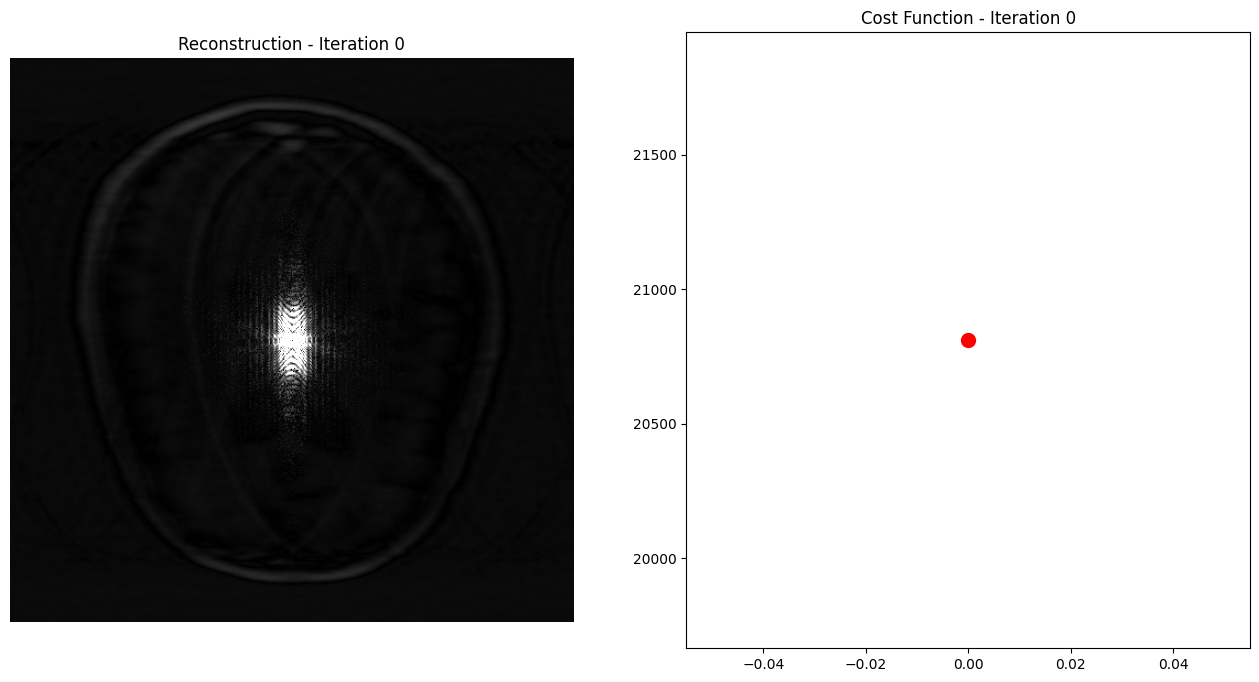

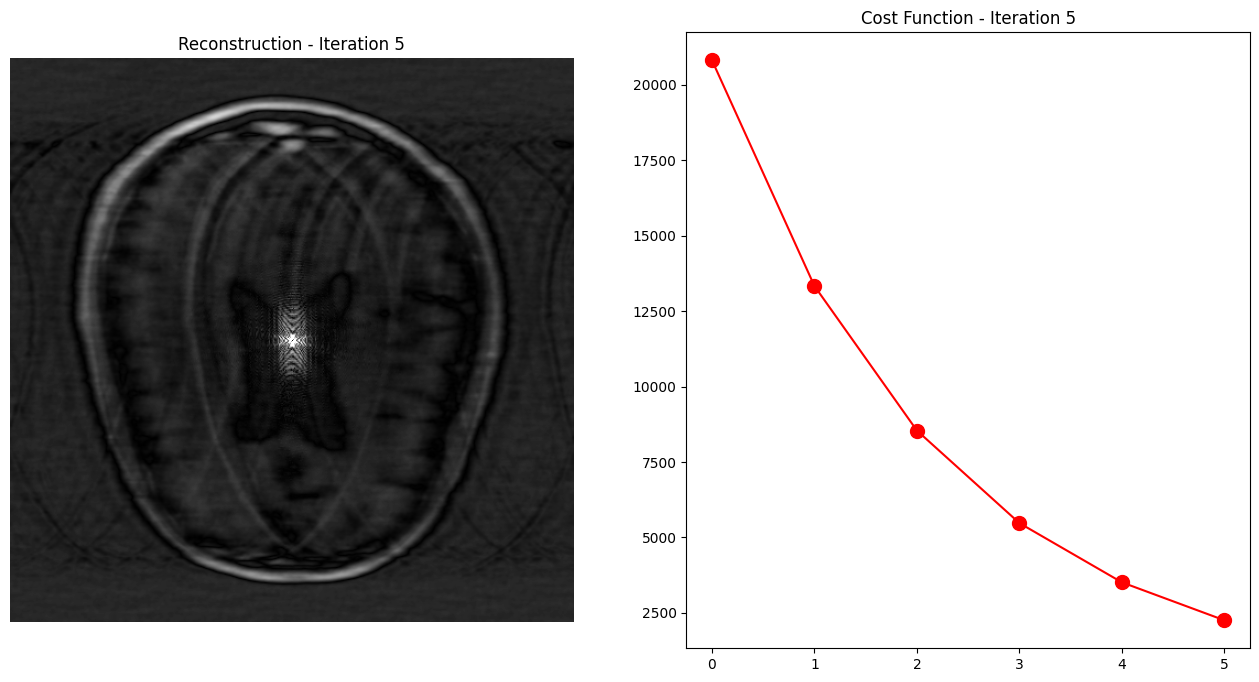

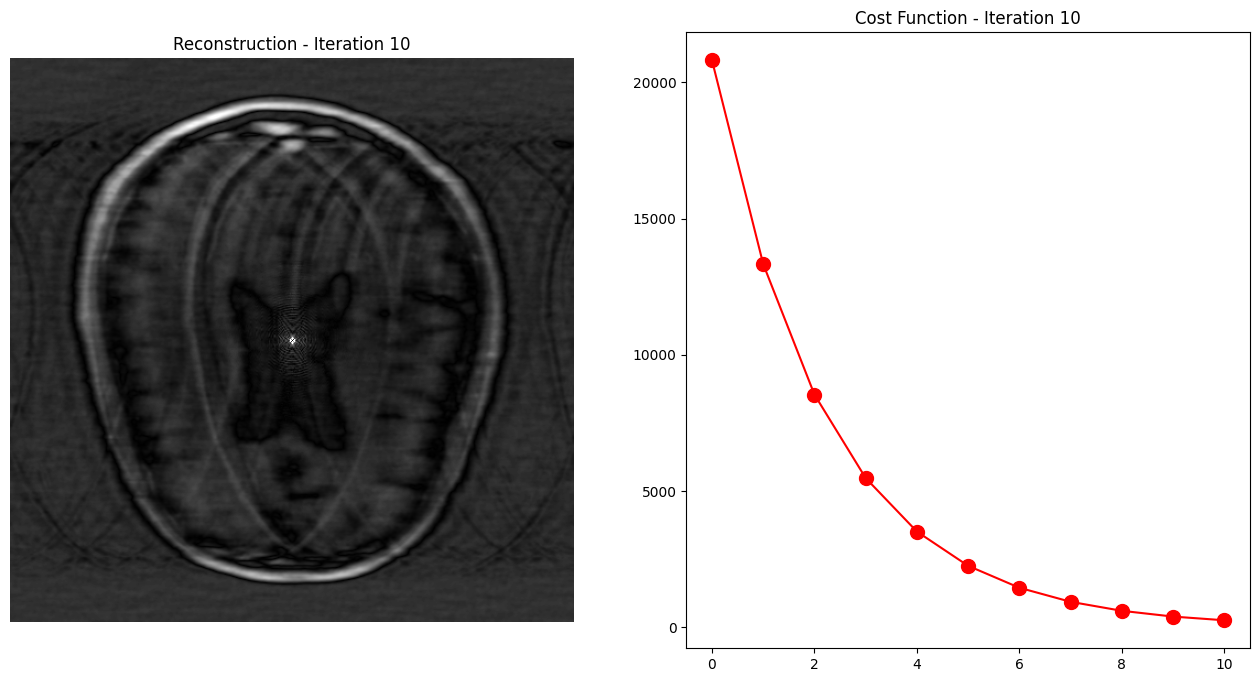

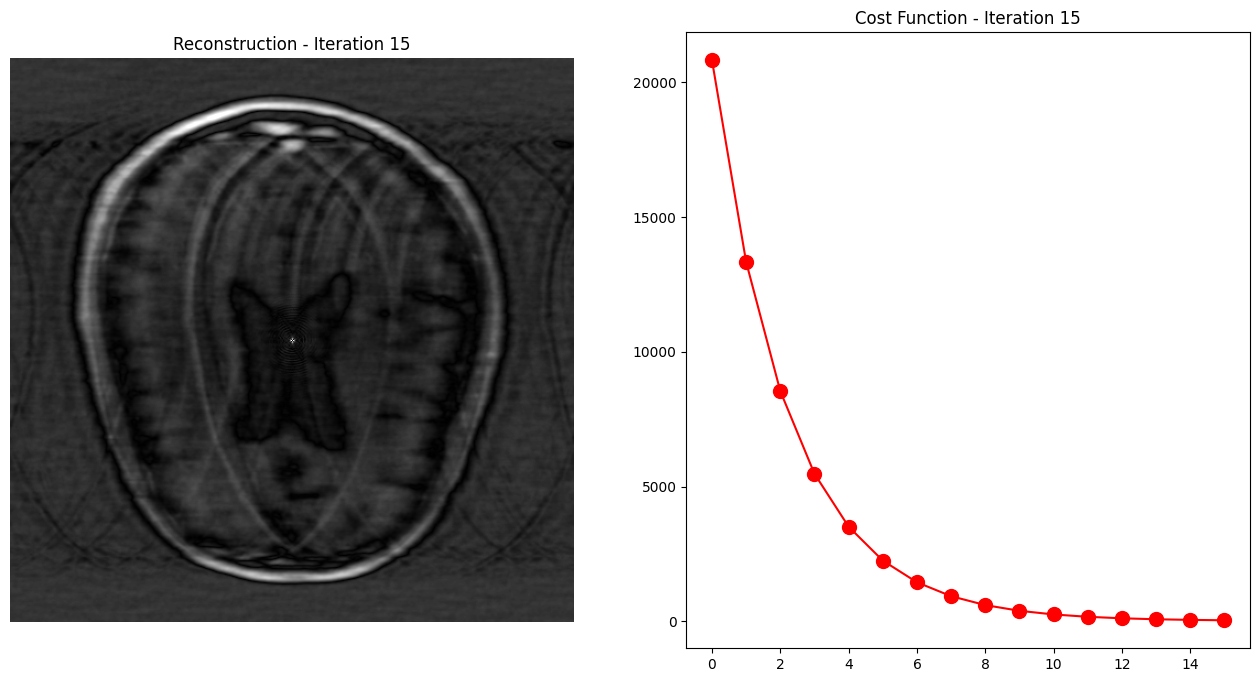

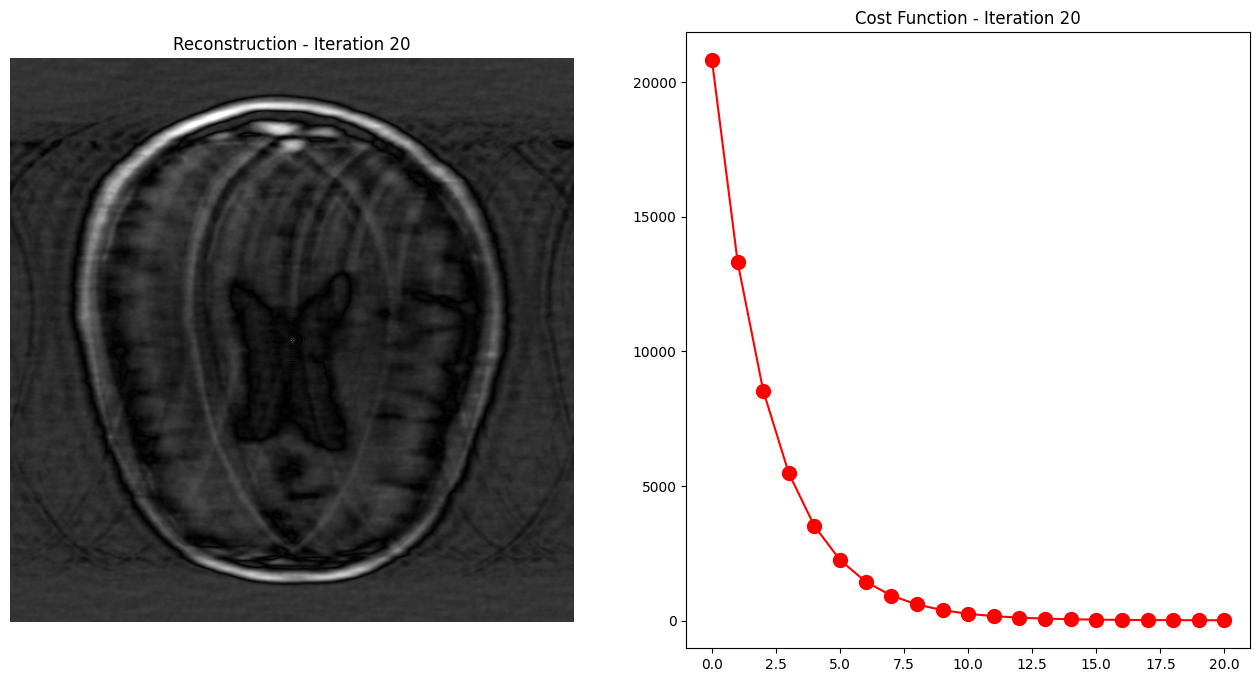

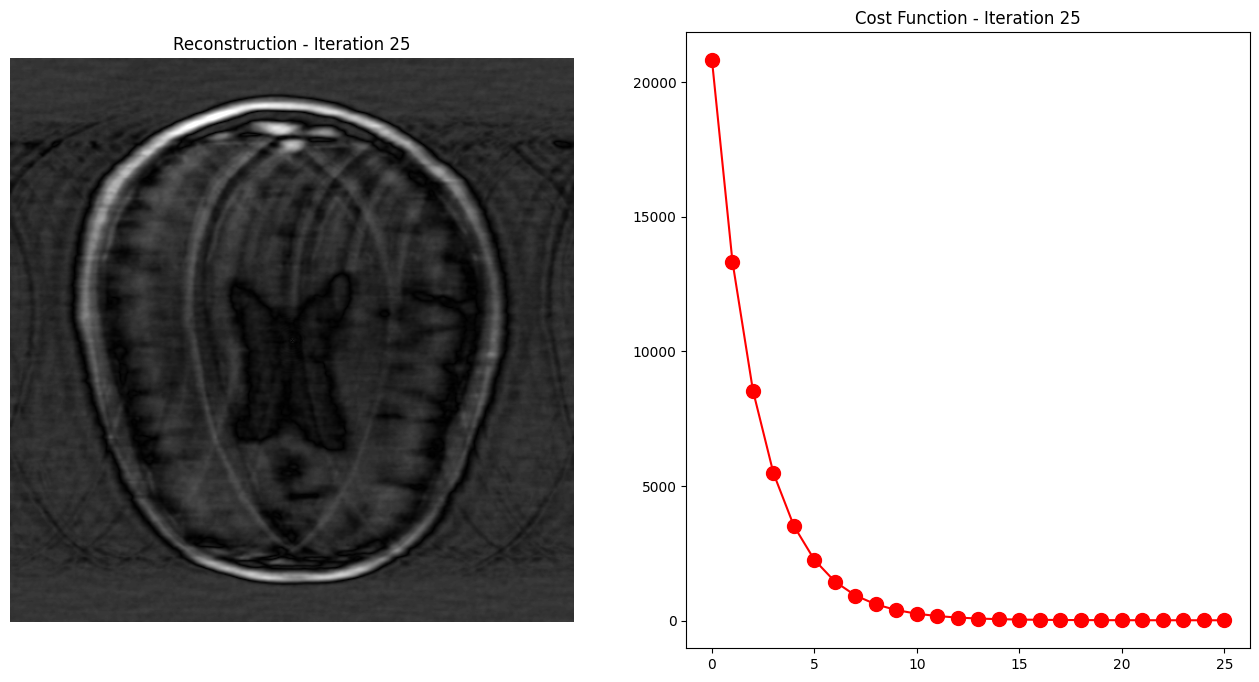

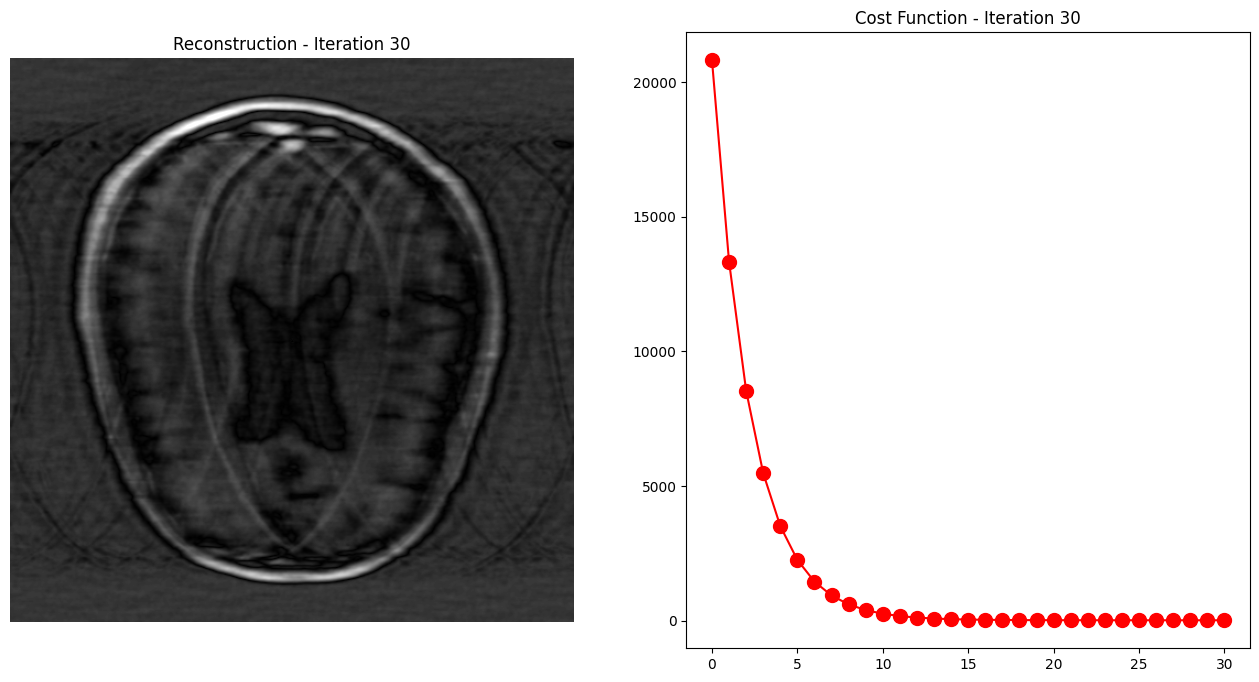

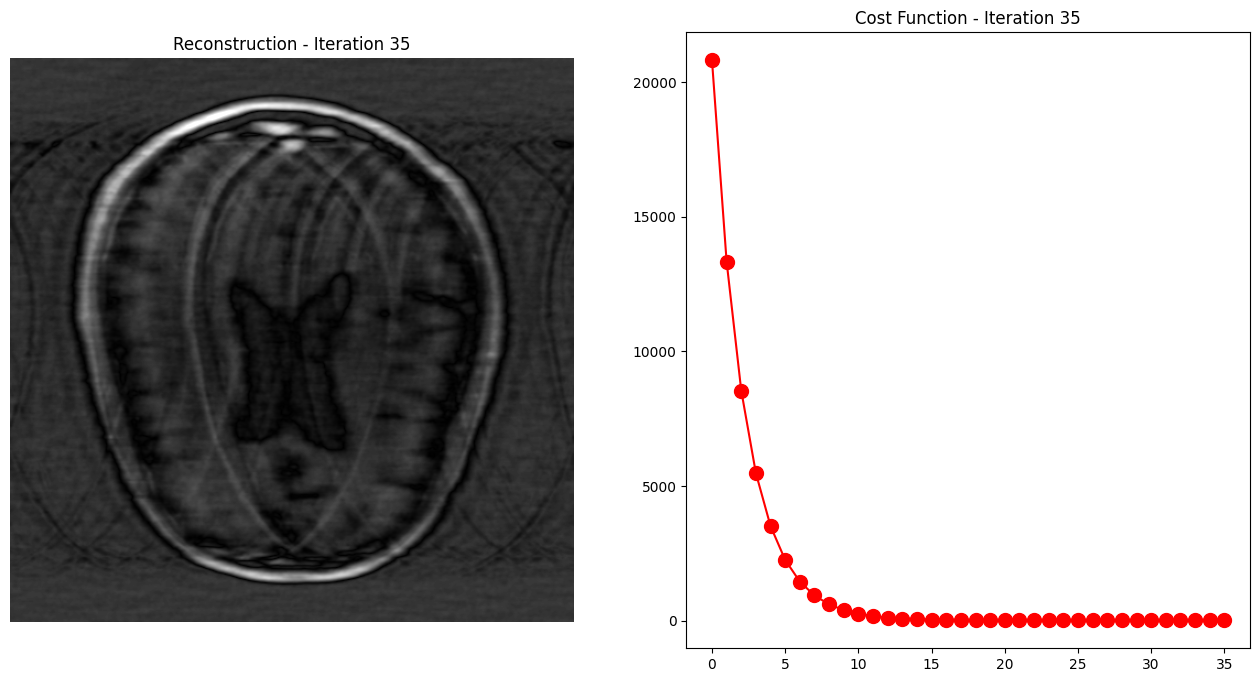

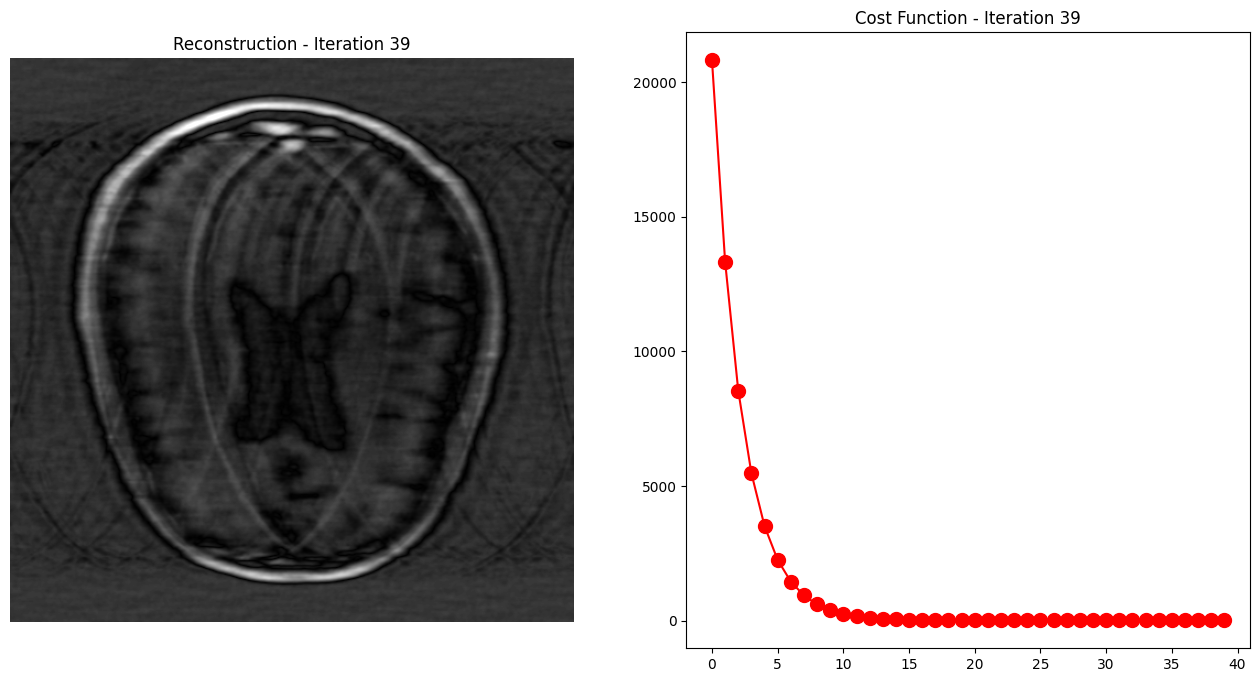

In [11]:
from src.cal import ista_CSmri
Nit = 40
alpha = 5
lam = 0.001
fac = 5

xhat, J = ista_CSmri(data, H, Ht, V, Vt, lam, alpha, Nit, fac, plot=True)

In [12]:
cs_output = []
for i in range(len(single_coil_rss)):
    img = single_coil_rss[i]
    img = (img - img.min()) / (img.max() - img.min()) # standardize the data to [0,1]
    img = (img - img.mean()) / img.std() # enhance contrast
    data = np.multiply(fft2c(img), den_mask)
    # print_info(data)
    xhat, J = ista_CSmri(data, H, Ht, V, Vt, lam, alpha, Nit, fac, plot=False)
    cs_output.append(xhat)
    print(len(cs_output), end='\r', flush=True)
cs_output = np.array(cs_output)

## ML Model (Unet - single coil model)
### Steps: 

`kspace  --IFT-->  multi-coil IMG  --ML-->  multi coil reconstruct --RSS--> reconstruct`

![](https://cds.ismrm.org/protected/21MProceedings/PDFfiles/images/4626/ISMRM2021-004626_Fig3.png)

In [13]:
from fastmri_recon.models.functional_models.unet import unet

model = unet(n_layers=4, layers_n_channels=[16, 32, 64, 128], layers_n_non_lins=2,)
model.load_weights('weight/UNet-fastmri.hdf5')


2024-10-10 21:34:49.153751: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2024-10-10 21:34:50.746531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there

In [14]:
model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                            

In [15]:
# kspace  --IFT-->  multi-coil
# 1. load multi-coil 
multi_coil = centre_crop(undersampled_image_IFT, (320,320))
batch_ift_img = (multi_coil * 255).astype(np.uint8) # (16, 4, 320, 320)   ,  multi slice + multi coil + IFT + crop

print_info(batch_ift_img)

uint8 (16, 4, 320, 320) [0, 255]


`resize to ML input size`

In [16]:
def run_unet_single_coil(zero_img_batch, means, stddevs, model):
    im_recos = model.predict_on_batch(zero_img_batch)
    im_recos = np.squeeze(im_recos)
    # print_info(im_recos)
    # im_recos = im_recos * np.array(stddevs)[:, None, None]
    # im_recos = np.matmul(im_recos, np.array(stddevs)[:, None, None])
    # im_recos = np.multiply(im_recos, np.array(stddevs)[:, None, None])
    for i in range(im_recos.shape[0]):
        im_recos[i] *= np.array(stddevs)[i]
        im_recos[i] += np.array(means)[i]

    # im_recos[:] = im_recos * np.array(stddevs)[:, None, None]
    # im_recos = im_recos + np.array(means)[:, None, None]
    return im_recos
def run_batch(multi_coils_slice, model):
    # [Pre-process] - resize
    # H W C for cv2.resize

    _, model_h , model_w, _ = model.input_shape
    print(model_h, model_w)
    multi_coils_slice = np.expand_dims(multi_coils_slice, axis=-1) # (16, 320, 320, 1) , float64
    multi_coils_slice = multi_coils_slice.astype(np.uint8) # (16, 4, 320, 320, 1), uint8
    # print_info(multi_coils_slice)
    # resize to 256 x 256 as model input

    zero_filled_batch_multi_coils_slice = np.zeros((16, 4, model_h, model_w, 1),dtype=np.uint8)
    for n in range(zero_filled_batch_multi_coils_slice.shape[0]):
        zero_filled_multi_coils_slice = np.zeros(zero_filled_batch_multi_coils_slice.shape[1:], dtype=np.uint8)
        for coil in range(zero_filled_multi_coils_slice.shape[0]):
            img = cv2.resize(multi_coils_slice[n,coil], (model_w, model_h))
            img = np.expand_dims(img, axis=-1)
            zero_filled_multi_coils_slice[coil] = img.copy()
        zero_filled_batch_multi_coils_slice[n] = zero_filled_multi_coils_slice.copy()


    # print_info(zero_filled_batch_multi_coils_slice)

    N, _, H, W, _ = multi_coils_slice.shape
    batch_recons = np.zeros((N, model_h, model_w), dtype=np.float32)
    for slice_idx, slice_ in enumerate(zero_filled_batch_multi_coils_slice):
        means = np.mean(slice_, axis=(1, 2))
        stddevs = np.std(slice_, axis=(1, 2))
        im_recos = run_unet_single_coil(slice_, means, stddevs, model)

        # Multi coil reconstruct --RSS combine--> single coil reconstruc
        # post-process : RSS , combine multi coil to single coil
        rss_recons = np.sqrt(np.sum(np.abs(im_recos)**2, axis=0))
        batch_recons[slice_idx] = rss_recons.copy()

    return batch_recons

batch_recons = run_batch(batch_ift_img, model)
print_info(batch_recons) # float32 (4, 256, 256) [4.405737400054932, 5276.947265625]

256 256


2024-10-10 21:34:51.643697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700


float32 (16, 256, 256) [1.7893214225769043, 8710.2724609375]


## Result and Comparison

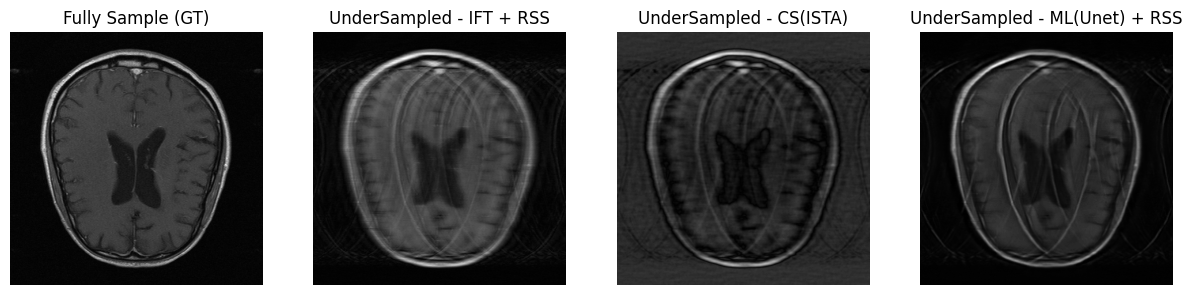

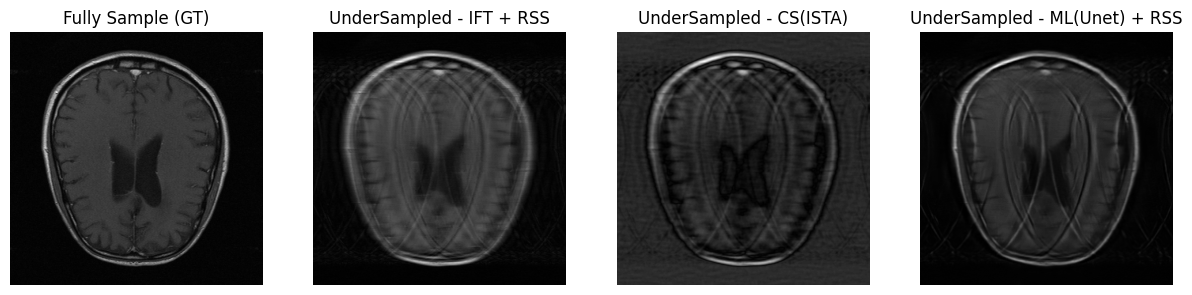

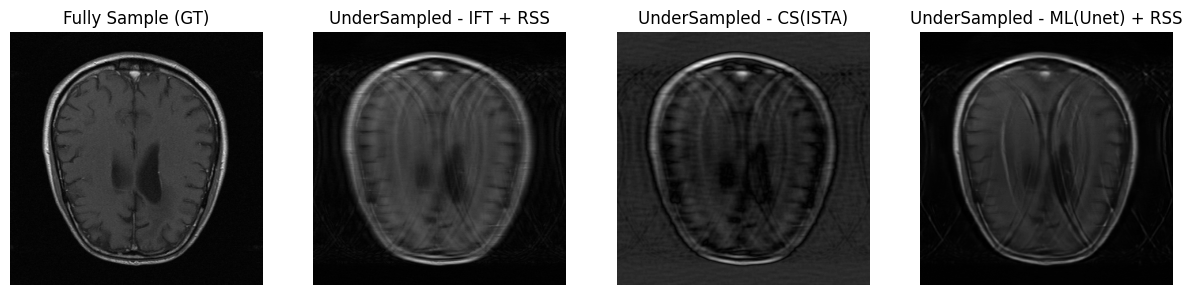

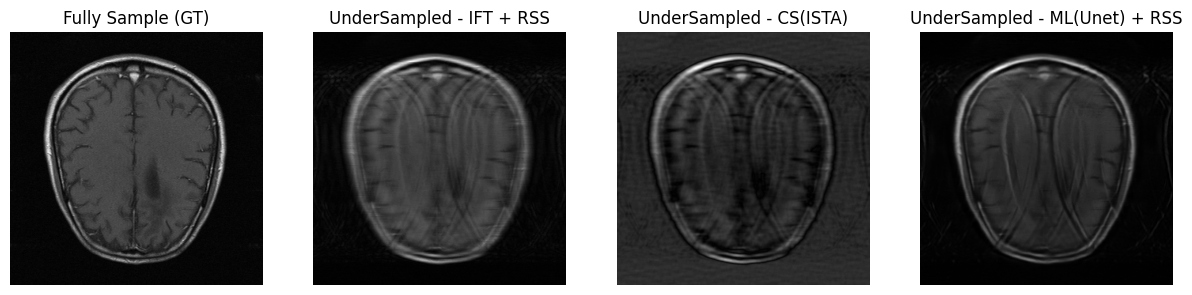

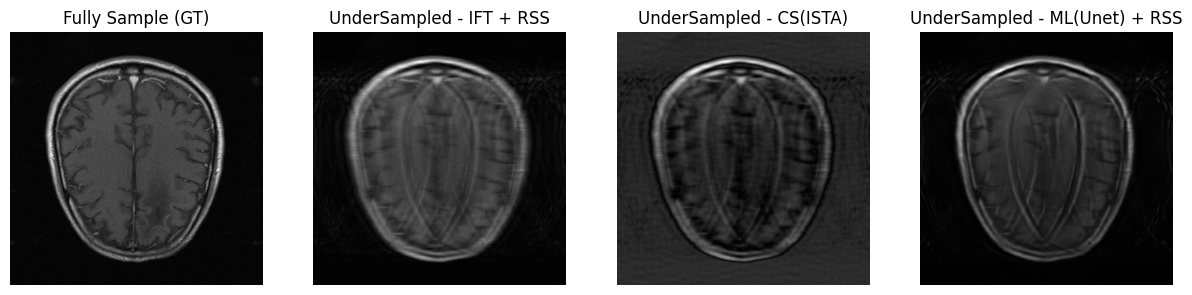

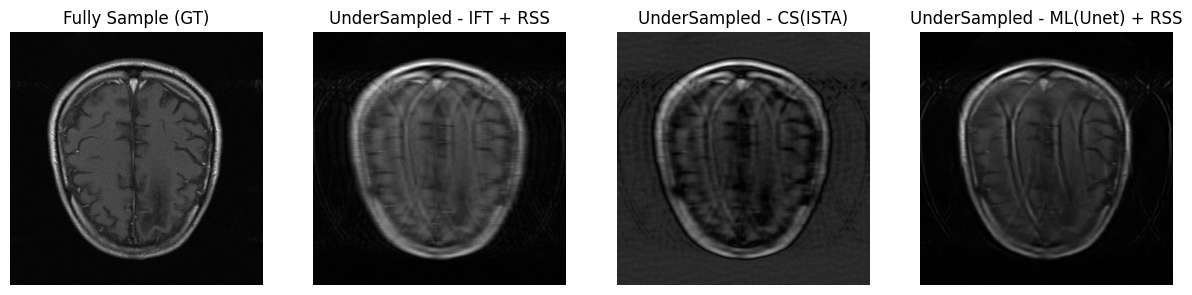

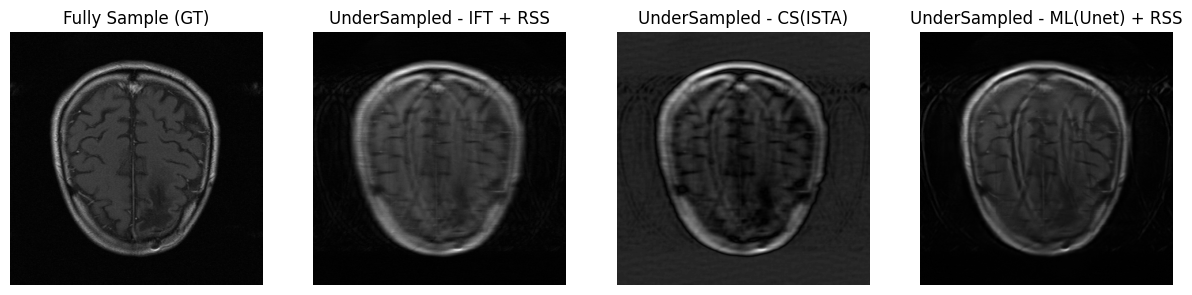

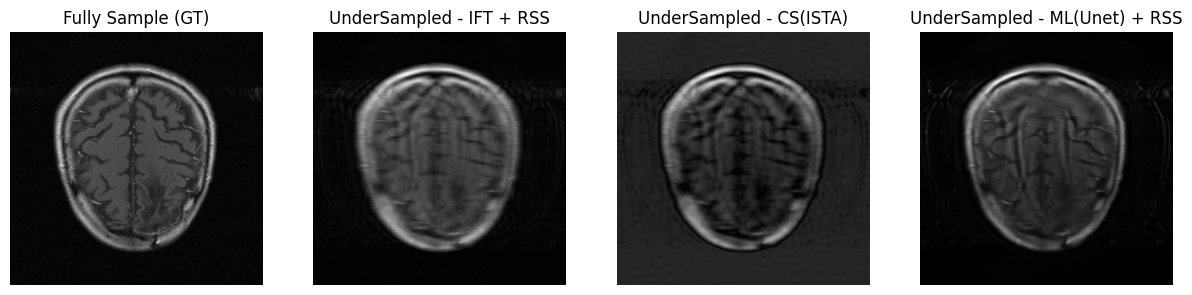

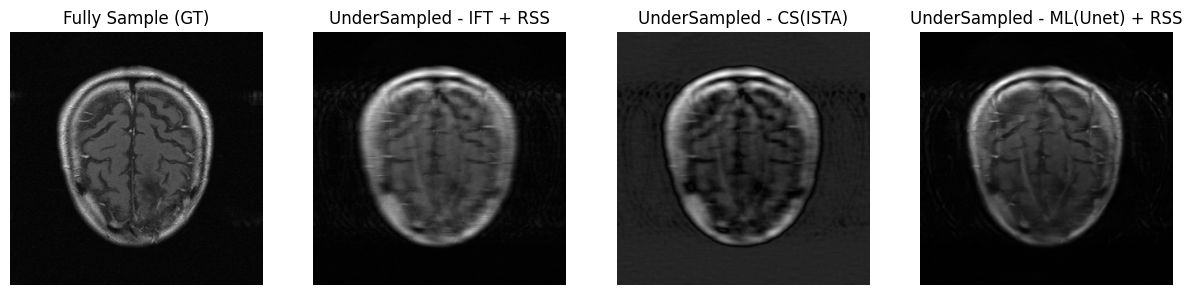

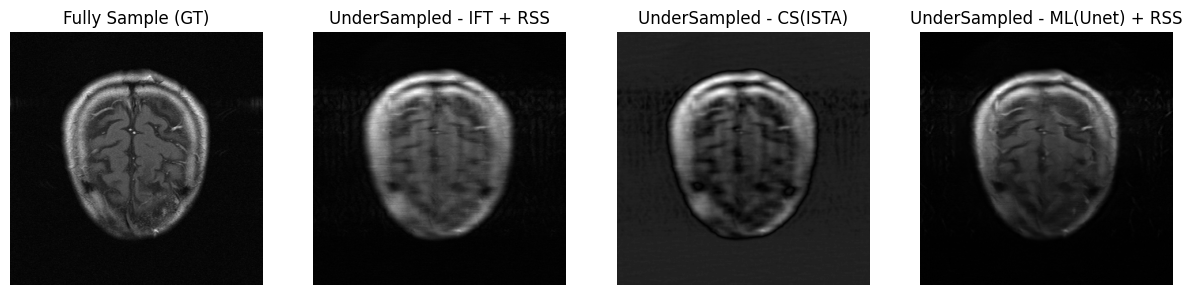

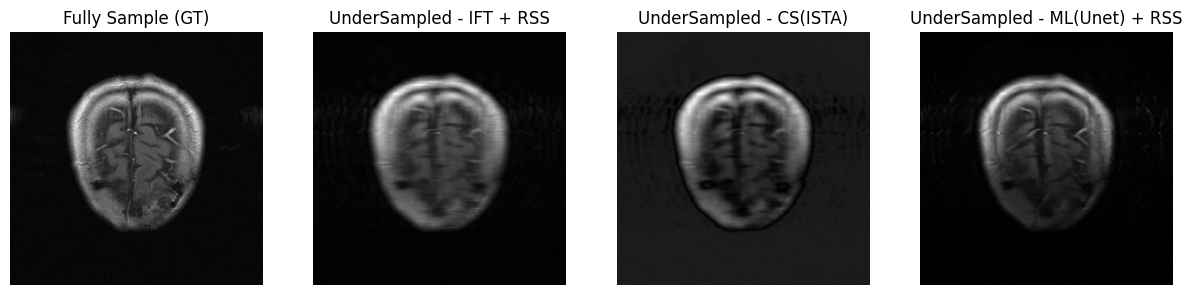

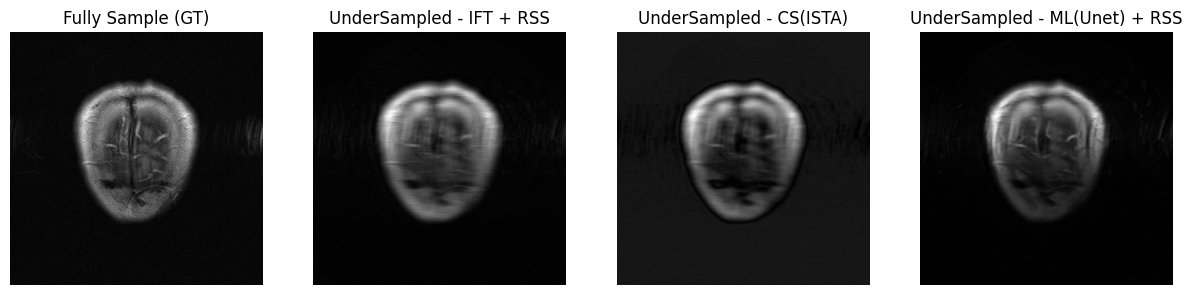

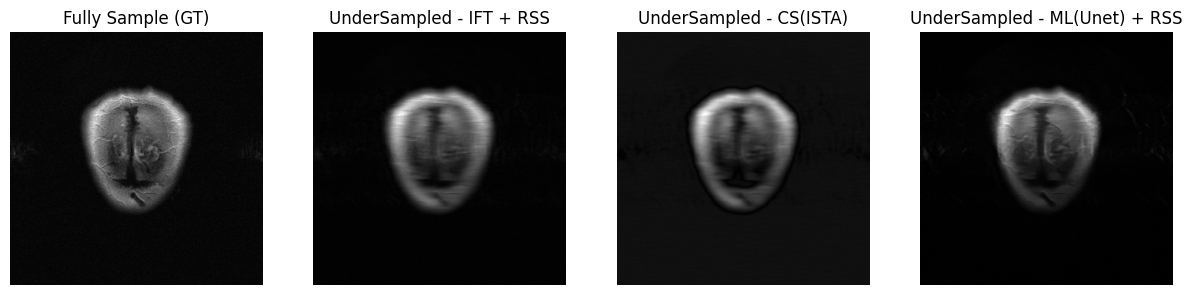

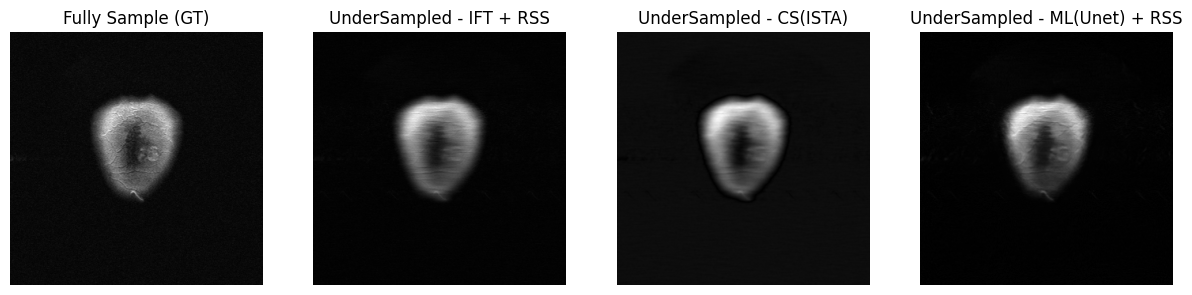

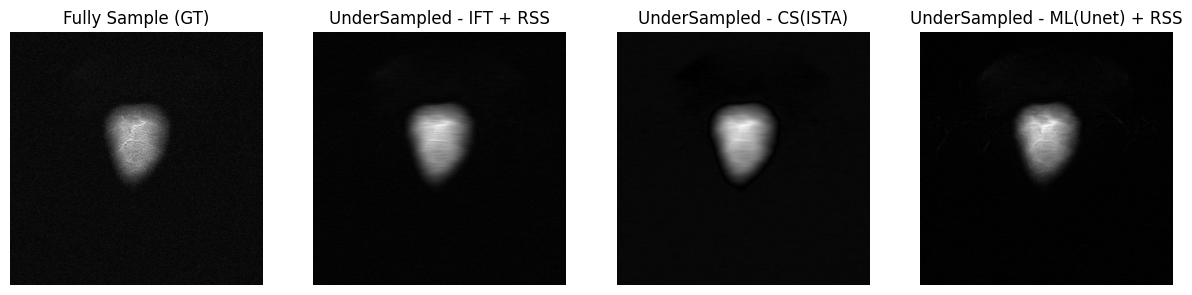

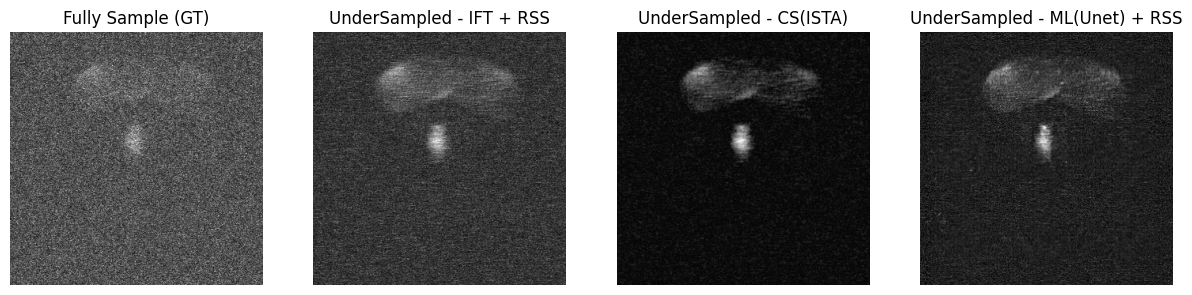

In [17]:
GT = np.mean(fully_smaple_image_IFT,axis=1)[:,160:480, 1:321]
for gt, input_img, cs_out, ml_out in zip(GT, undersampled_rss, cs_output, batch_recons):
    plot({"Fully Sample (GT)": gt, "UnderSampled - IFT + RSS": input_img, "UnderSampled - CS(ISTA)": abs(cs_out), "UnderSampled - ML(Unet) + RSS": ml_out})